# Demonstration of `DroneWQ` functions and processing code

Pull in all the modules needed for this code.

In [50]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
# from georeg import *

import random
import cameratransform as ct
from rasterio.merge import merge

In [51]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

To process raw MicaSense imagery to corrected remote sensing reflectance (Rrs) imagery, you can use the `process_raw_to_rrs()` function. 

Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want and put that into the function and keep the rest exactly as named here:
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to <main_dir> below:

In [52]:
project_path = os.path.join('sample_datasets','estuarine_dataset/')
#project_path = os.path.join('sample_datasets','open_ocean_dataset/')
#project_path = os.path.join('sample_datasets','lake_dataset/')
project_path

'sample_datasets/estuarine_dataset/'

The `process_raw_to_rrs()` function has a number of options that you can see here:

In [53]:
?process_raw_to_rrs

Signature:
process_raw_to_rrs(
    main_dir,
    rrs_dir_name,
    output_csv_path,
    lw_method='mobley_rho_method',
    random_n=10,
    mask_pixels=False,
    pixel_masking_method='value_threshold',
    mask_std_factor=1,
    nir_threshold=0.01,
    green_threshold=0.005,
    ed_method='dls_ed',
    overwrite=False,
    clean_intermediates=True,
)
Docstring:
This functions is the main processing script that processs raw imagery to units of remote sensing reflectance (Rrs). Users can select which processing parameters to use to calculate Rrs.

Inputs: 
main_dir: A string containing the main image directory
rrs_dir_name: A string containing the directory filepath of new rrs images
output_csv_path: A string containing the filepath to write the metadata.csv 
lw_method: Method used to calculate water leaving radiance. Default is mobley_rho_method().
random_n: The amount of random images to calculate ambient NIR level. Default is 10. Only need if lw_method = 'hedley_method'
mask_pixels: 

Below we show an example of this function in action with one of our provided sample datasets. For this example, we're calculating water leaving radiance (Lw) using the Mobley approach, calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS) corrected by the calibrated reflectance panel. We are not applying a masking procedure. We'll save this out in a directory called `rrs_mobley`.

### Raw -> Lt -> Lw (Mobley method) -> Rrs (Panel) w/o pixel masking

In [54]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_mobley', output_csv_path=project_path, lw_method='mobley_rho_method', 
                   mask_pixels=False, ed_method='dls_and_panel_ed', overwrite=True, clean_intermediates=False)

#process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', 
#                   mask_pixels=False, ed_method='panel_ed', overwrite=True, clean_intermediates=False)

Processing a total of 144 captures or 29 image sets.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: sample_datasets/estuarine_dataset//raw_water_imgs
Loading ImageSet from: sample_datasets/estuarine_dataset/align_img
used warp dir sample_datasets/estuarine_dataset/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 4
Finished aligning band 3
Finished aligning band 1


/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:01:41.661713
Alignment+Saving rate: 0.24 images per second
Finished saving images.
Finished saving image metadata.
Converting raw sky images to radiance (raw sky -> Lsky).
Loading ImageSet from: sample_datasets/estuarine_dataset//raw_sky_imgs
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 3
Finished aligning band 1
Finished aligning band 2
Finished aligning band 4


/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)
/home/jovyan/DroneWQ/micasense/imageutils.py:53: FutureWarning: `selem` is a deprecated argument name for `equalize`. It will be removed in version 1.0. Please use `footprint` instead.
  norm2 = rank.equalize(norm, selem=selem)


Saving time: 0:00:21.662830
Alignment+Saving rate: 0.28 images per second
Finished saving images.
Finished saving image metadata.
Applying the mobley_rho_method (Lt -> Lw).
Normalizing by DLS corrected by panel irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: sample_datasets/estuarine_dataset/raw_water_imgs
Loading ImageSet from: sample_datasets/estuarine_dataset/panel
[0.88814444 1.19410482 1.1758929  1.36222372 1.33612593]
All data has been saved as Rrs using the mobley_rho_method to calcualte Lw and normalized by dls_and_panel_ed irradiance.
Not masking pixels.


True

To now grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows for an easier altitude cutoff and limit to the number of files being opened. 

Note that this will open as many files as you ask and if you have 1000+ images this is likely more than you can load into memory. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

In [6]:
?retrieve_imgs_and_metadata

#### First lets see the total surface radiance data

In [55]:
lt_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')

And let's visualize some of this data just to make sure it is reasonable.

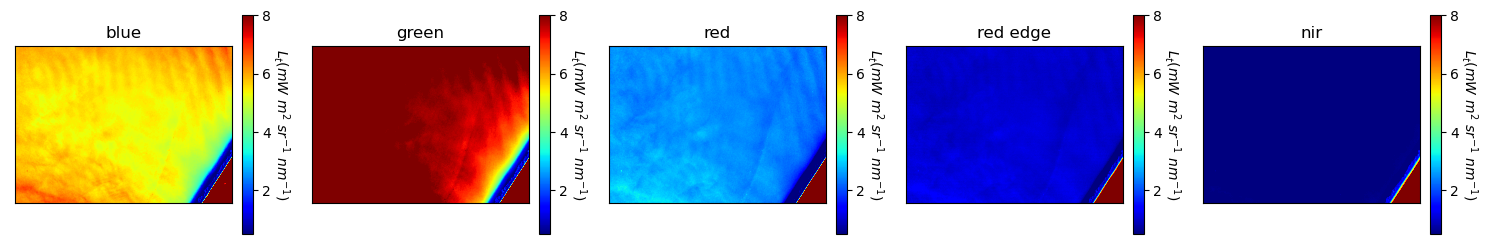

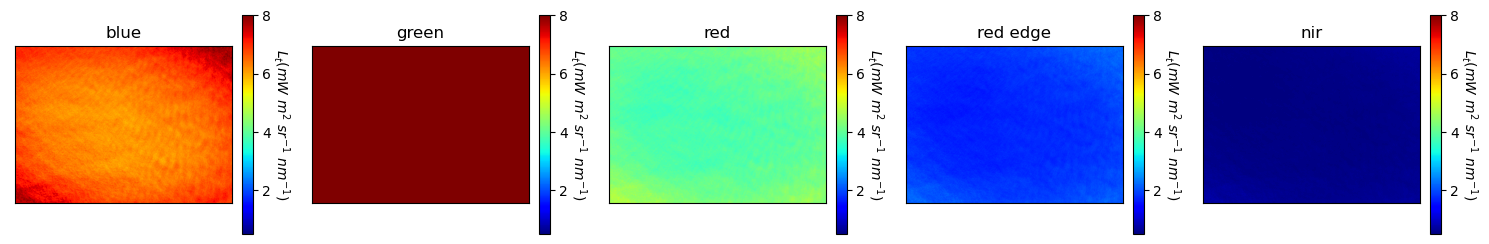

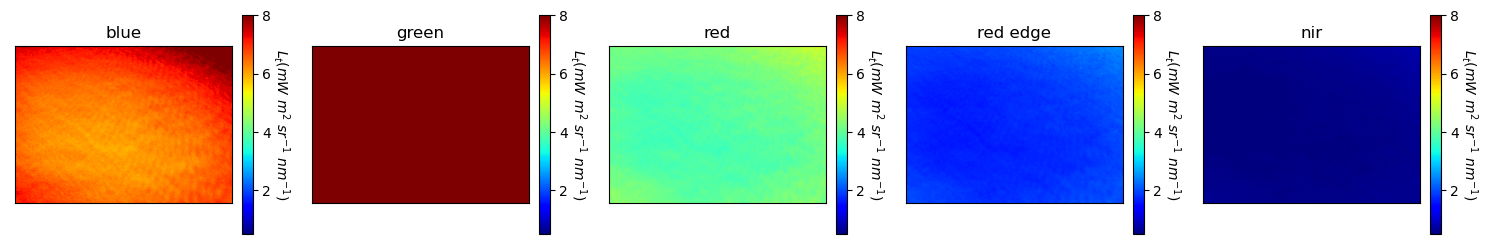

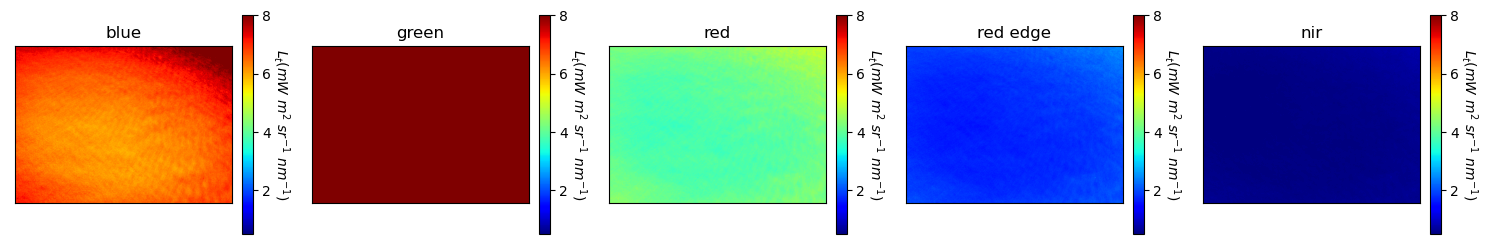

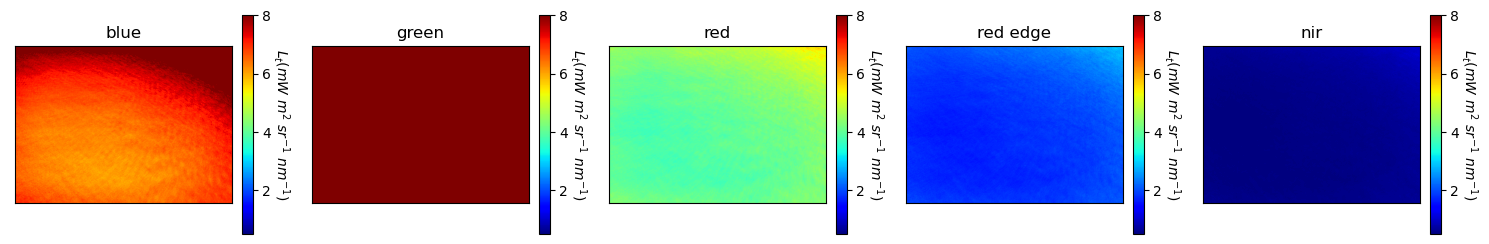

In [56]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(lt_imgs[:5])):
    fig, ax = plt.subplots(1,5, figsize=(15,3.5))
    for i in range(5):
        im = ax[i].imshow(lt_imgs[j,i],cmap='jet', vmin=0.5, vmax=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
        cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.set_label('$L_{t} (mW\ m^2\ sr^{-1}\ nm^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

#### now with the Rrs data

In [57]:
rrs_imgs_mobley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_mobley', count=5)

#rrs_imgs_mobley, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley', count=5)

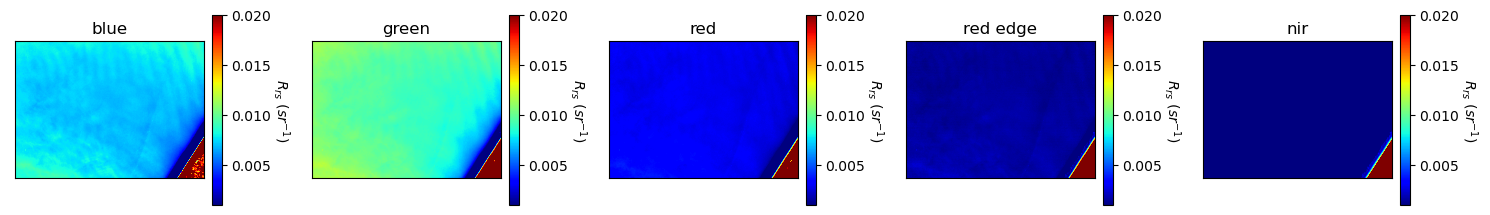

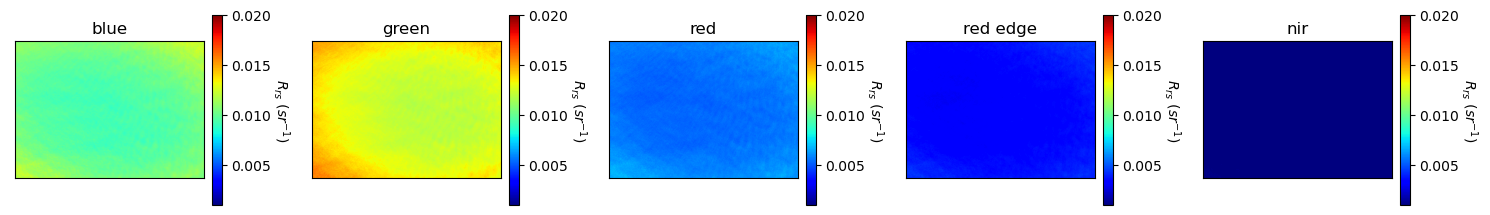

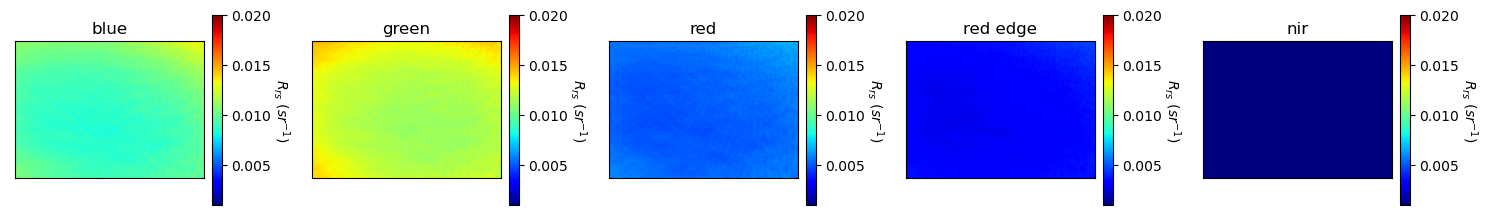

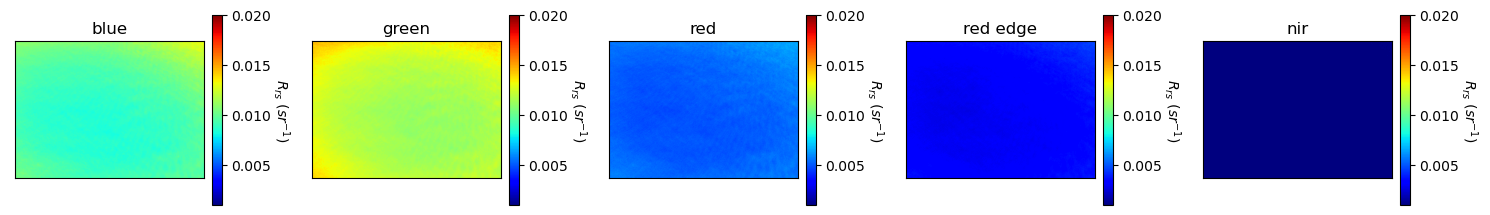

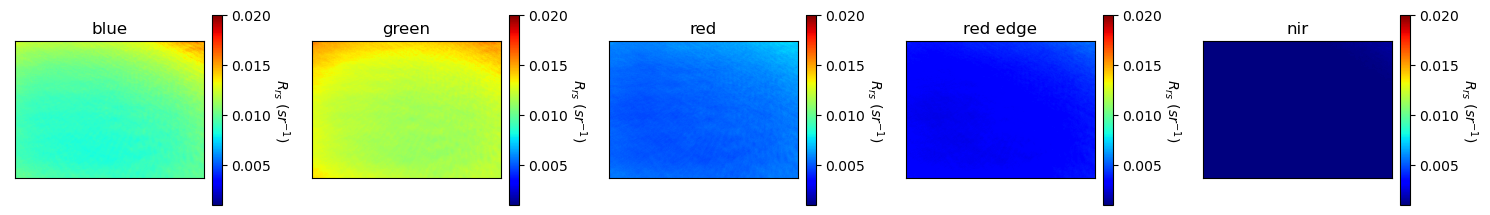

In [58]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_mobley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(15,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_mobley[j,i],cmap='jet', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
        cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

## View metadata 

Metadata is the same for each processed dataset

In [59]:
rrs_img_metadata.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,sample_datasets/estuarine_dataset/capture_1.tif,2021:04:07,13:26:31,34.715206,N,-76.673312,W,22.412,7.783703,2064,1544,-95.612125,-4.809893,4.833103,2021-04-07 13:26:31
capture_2.tif,sample_datasets/estuarine_dataset/capture_2.tif,2021:04:07,13:31:08,34.714973,N,-76.675288,W,34.022,7.783703,2064,1544,-98.253559,-0.269329,9.414915,2021-04-07 13:31:08
capture_3.tif,sample_datasets/estuarine_dataset/capture_3.tif,2021:04:07,13:31:11,34.714974,N,-76.675289,W,34.064,7.783703,2064,1544,-97.252677,0.166681,9.188154,2021-04-07 13:31:11
capture_4.tif,sample_datasets/estuarine_dataset/capture_4.tif,2021:04:07,13:31:13,34.714975,N,-76.675291,W,33.897,7.783703,2064,1544,-96.242855,0.317755,9.093116,2021-04-07 13:31:13
capture_5.tif,sample_datasets/estuarine_dataset/capture_5.tif,2021:04:07,13:31:16,34.714975,N,-76.675295,W,33.118,7.783703,2064,1544,-95.169319,0.503772,9.040661,2021-04-07 13:31:16


### Plot altitude and lat, lon

Text(0.5, 0, 'Longitude')

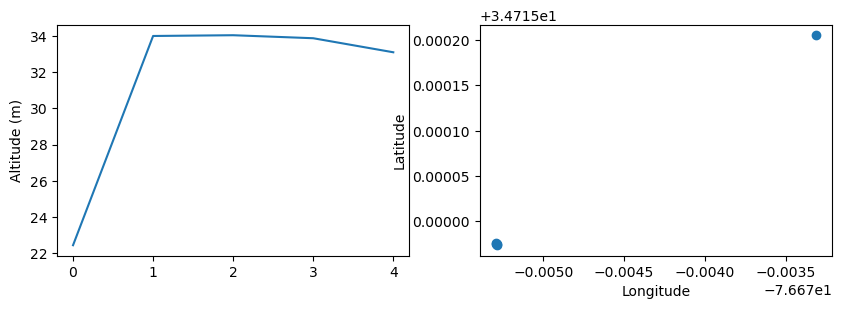

In [60]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(list(range(len(rrs_img_metadata))),rrs_img_metadata['GPSAltitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(rrs_img_metadata['GPSLongitude'], rrs_img_metadata['GPSLatitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

### Save mean Rrs for each image in dataframe

In [61]:
rrs_blue = []
rrs_green = []
rrs_red = []
rrs_rededge = []
rrs_nir= []

for i in range(len(rrs_imgs_mobley)):
    rrs_blue.append(np.nanmean(rrs_imgs_mobley[i,0,:,:]))
    rrs_green.append(np.nanmean(rrs_imgs_mobley[i,1,:,:]))
    rrs_red.append(np.nanmean(rrs_imgs_mobley[i,2,:,:]))
    rrs_rededge.append(np.nanmean(rrs_imgs_mobley[i,3,:,:]))
    rrs_nir.append(np.nanmean(rrs_imgs_mobley[i,4,:,:]))
    
df = rrs_img_metadata[['SourceFile', 'GPSLatitude', 'GPSLongitude']]
df['rrs_blue'] = rrs_blue
df['rrs_green'] = rrs_green
df['rrs_red'] = rrs_red
df['rrs_rededge'] = rrs_rededge
df['rrs_nir'] = rrs_nir    
df

,SourceFile,GPSLatitude,GPSLongitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir
filename,,,,,,,,
capture_1.tif,sample_datasets/estuarine_dataset/capture_1.tif,34.715206,-76.673312,0.007703,0.009808,0.003692,0.002957,0.001045
capture_2.tif,sample_datasets/estuarine_dataset/capture_2.tif,34.714973,-76.675288,0.009988,0.012878,0.005613,0.003468,0.000775
capture_3.tif,sample_datasets/estuarine_dataset/capture_3.tif,34.714974,-76.675289,0.009486,0.012149,0.005302,0.003275,0.000723
capture_4.tif,sample_datasets/estuarine_dataset/capture_4.tif,34.714975,-76.675291,0.009385,0.012028,0.005248,0.003241,0.000714
capture_5.tif,sample_datasets/estuarine_dataset/capture_5.tif,34.714975,-76.675295,0.009862,0.012334,0.005418,0.003383,0.000768


In [62]:
#save as csv
df.to_csv(project_path + '/mean_rrs.csv')

### Rrs -> Chlorophyll a (Chl-a)/Total Suspended Matter (TSM)

This runs four different chl-a algorithms and one TSM algorithm on every pixel of the Rrs data.

In [63]:
chl_hu_imgs = chl_hu(Rrsblue=rrs_imgs_mobley[:,0,:,:], Rrsgreen=rrs_imgs_mobley[:,1,:,:], Rrsred=rrs_imgs_mobley[:,2,:,:])
chl_ocx_imgs = chl_ocx(Rrsblue=rrs_imgs_mobley[:,0,:,:], Rrsgreen=rrs_imgs_mobley[:,1,:,:])
chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=rrs_imgs_mobley[:,0,:,:], Rrsgreen=rrs_imgs_mobley[:,1,:,:], Rrsred=rrs_imgs_mobley[:,2,:,:])
chl_gitelson_imgs = chl_gitelson(Rrsred=rrs_imgs_mobley[:,2,:,:], Rrsrededge=rrs_imgs_mobley[:,3,:,:])
nechad_tsm_imgs = nechad_tsm(Rrsred=rrs_imgs_mobley[:,2,:,:])

### Save mean chl-a/TSM concentrations for each image in dataframe

In [64]:
chl_hu_values = []
chl_ocx_values = []
chl_hu_ocx_values = []
chl_gitelson_values = []
nechad_tsm_values = []

for i in range(len(rrs_imgs_mobley)):
    chl_hu_values.append(np.nanmean(chl_hu_imgs[i,:,:]))
    chl_ocx_values.append(np.nanmean(chl_ocx_imgs[i,:,:]))
    chl_hu_ocx_values.append(np.nanmean(chl_hu_ocx_imgs[i,:,:]))
    chl_gitelson_values.append(np.nanmean(chl_gitelson_imgs[i,:,:]))
    nechad_tsm_values.append(np.nanmean(nechad_tsm_imgs[i,:,:]))

df['chl_hu'] = chl_hu_values
df['chl_ocx'] = chl_ocx_values
df['chl_hu_ocx'] = chl_hu_ocx_values
df['chl_gitelson'] = chl_gitelson_values
df['nechad_tsm'] = nechad_tsm_values

df

,SourceFile,GPSLatitude,GPSLongitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir,chl_hu,chl_ocx,chl_hu_ocx,chl_gitelson,nechad_tsm
filename,,,,,,,,,,,,,
capture_1.tif,sample_datasets/estuarine_dataset/capture_1.tif,34.715206,-76.673312,0.007703,0.009808,0.003692,0.002957,0.001045,3.833568e+07,1.431920e+18,1.431920e+18,14.117490,2.992378
capture_2.tif,sample_datasets/estuarine_dataset/capture_2.tif,34.714973,-76.675288,0.009988,0.012878,0.005613,0.003468,0.000775,2.823368e+00,2.646089e+00,2.646089e+00,19.424662,3.710375
capture_3.tif,sample_datasets/estuarine_dataset/capture_3.tif,34.714974,-76.675289,0.009486,0.012149,0.005302,0.003275,0.000723,2.452311e+00,2.625044e+00,2.625044e+00,19.384607,3.594244
capture_4.tif,sample_datasets/estuarine_dataset/capture_4.tif,34.714975,-76.675291,0.009385,0.012028,0.005248,0.003241,0.000714,2.406489e+00,2.628177e+00,2.628177e+00,19.380346,3.573994
capture_5.tif,sample_datasets/estuarine_dataset/capture_5.tif,34.714975,-76.675295,0.009862,0.012334,0.005418,0.003383,0.000768,2.374718e+00,2.527233e+00,2.527233e+00,19.719486,3.637718


In [65]:
#save as csv
df.to_csv(project_path + '/mean_rrs_and_wq.csv')

### Map average chl-a/TSM concentrations 

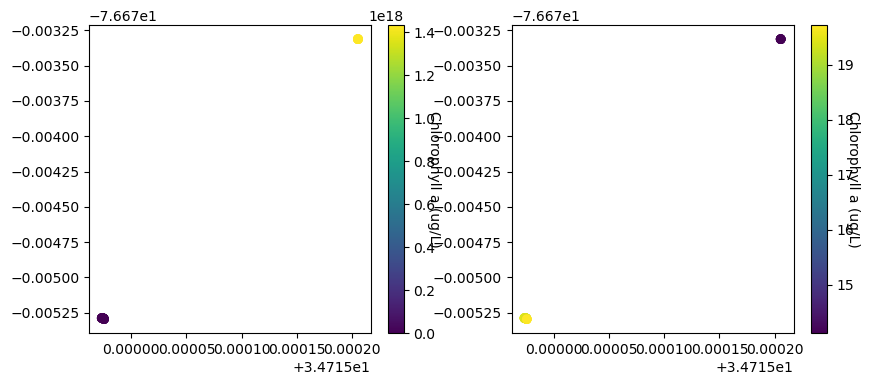

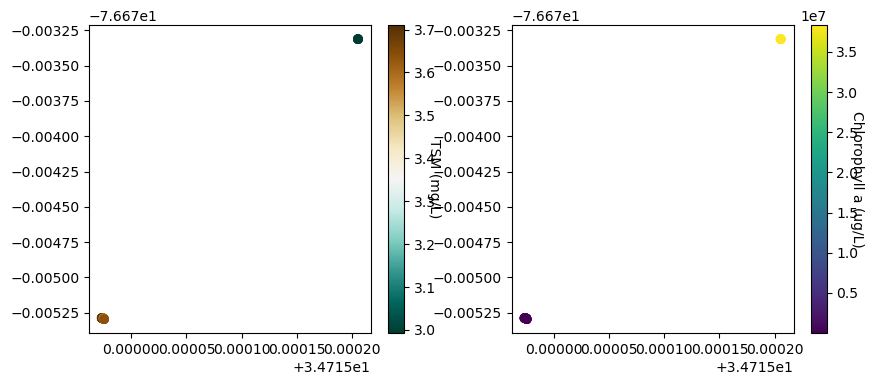

In [66]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(df)):  
    g1 = ax[0].scatter(df['GPSLatitude'], df['GPSLongitude'], c=df['chl_ocx'])
    g2 = ax[1].scatter(df['GPSLatitude'], df['GPSLongitude'], c=df['chl_gitelson'])

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270)


fig1, ax = plt.subplots(1,2, figsize=(10,4))
for i in range(len(df)):  
    g1 = ax[0].scatter(df['GPSLatitude'], df['GPSLongitude'], c=df['nechad_tsm'], cmap='BrBG_r')
    g2 = ax[1].scatter(df['GPSLatitude'], df['GPSLongitude'], c=df['chl_hu'])

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('TSM (mg/L)', rotation=270)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270)

### Georeferencing 


We have included code that allow the user to georeference an image based entirely on the drone sensor yaw, pitch, roll, lat, lon, and altitude. While this can be inaccurate if the yaw, pitch, and roll information is imprecise, it is the best option given that structure from motion algorithms does not work in most aquatic environments. With highly accurate pose and geolocation information this can lead to great results and even be mosaicked. See `georeferencing_improved.ipynb` for a demonstration on how to do this. 

In [67]:
# if you have a pitch offset ensure you add it correctly!
pitch_offset = 25
#pitch_offset = 0

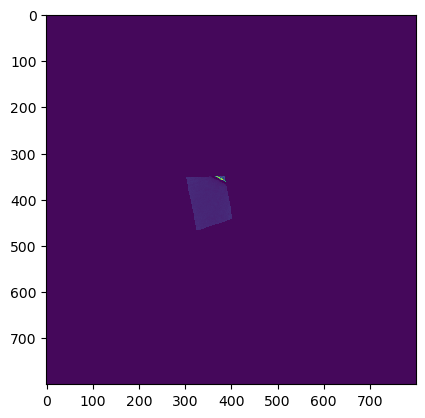

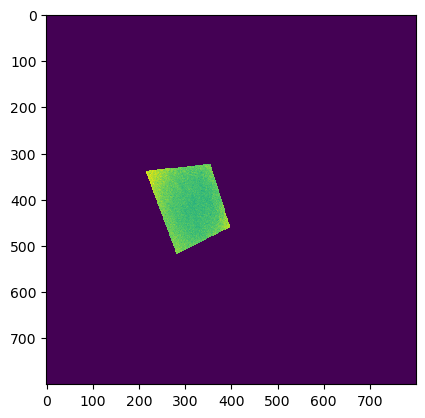

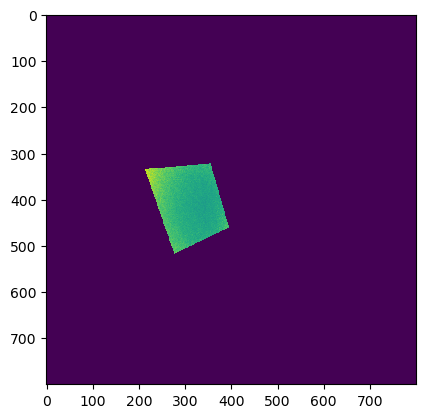

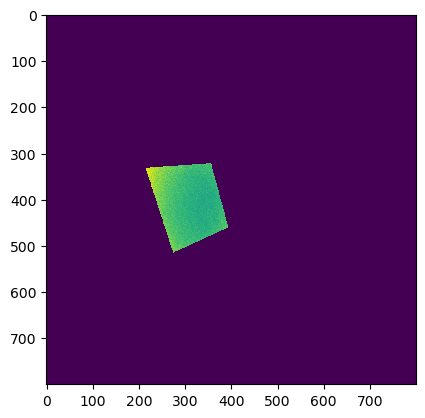

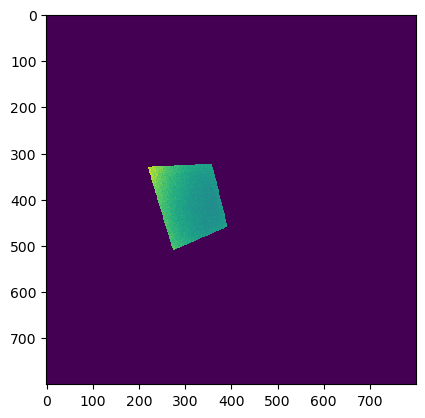

True

In [68]:
georeference(main_dir=project_path, img_dir=project_path+'rrs_mobley', output_dir_name=project_path+'georeferenced_rrs_mobley', imgs=rrs_imgs_mobley, 
             img_metadata=rrs_img_metadata, pitch_offset=pitch_offset, plot=True)

#georeference(main_dir=project_path, img_dir=project_path+'rrs_hedley', output_dir_name=project_path+'georeferenced_rrs_mobley', imgs=rrs_imgs_mobley, 
#             img_metadata=rrs_img_metadata, pitch_offset=pitch_offset, extent=80, flip=True, plot=True)

(5, 930, 1707)


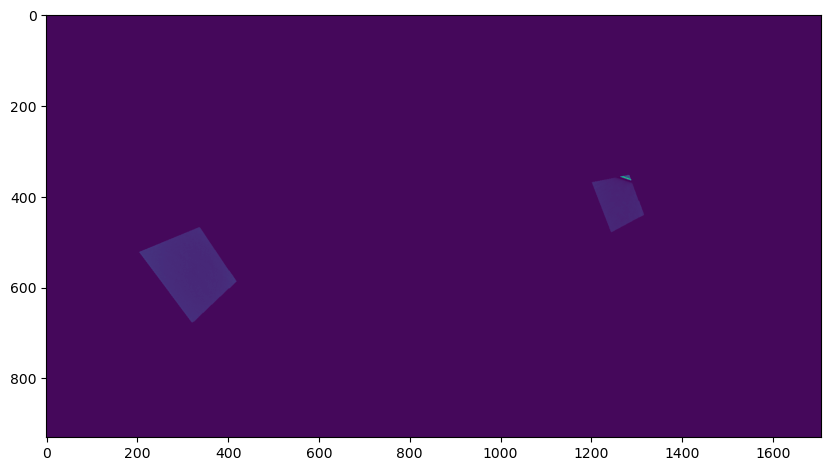

In [69]:
foo = mosaic(main_dir=project_path, img_dir=project_path+'/georeferenced_rrs_mobley_improved', output_name='mosaic', plot=True, save=True, band_to_plot=0)
print(foo.shape)

### Save georeferenced .tifs with units of Chl-a/TSM concentration

We have included a function to save new georeferenced.tifs with units Chl-a/TSM concentration for each image capture.

In [70]:
save_wq_imgs(main_dir=project_path, rrs_img_dir=project_path+'georeferenced_rrs_mobley',
    wq_dir_name=project_path+'chl_hu_ocx_imgs', wq_alg="chl_hu_ocx", imgs=rrs_imgs_mobley,
    img_metadata=rrs_img_metadata, start=0, count=10000)